第二部分地区：使用sarima模型 \
该部分城市的后两年数据均由线性方法填充，因此采用评估范围更大。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=482.538, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=483.703, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=480.103, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=475.397, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=481.819, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=477.120, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=477.990, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=475.566, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.262 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=506.147, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=509.822, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=504.498, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=508.338, Time=0.02 

C:\Users\admin\AppData\Local\Temp\ipykernel_2780\3553116152.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=506.141, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=505.820, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.159 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=562.843, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=554.396, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=556.368, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=556.372, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=578.929, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=558.561, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.081 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=511.797, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=508.299, Ti

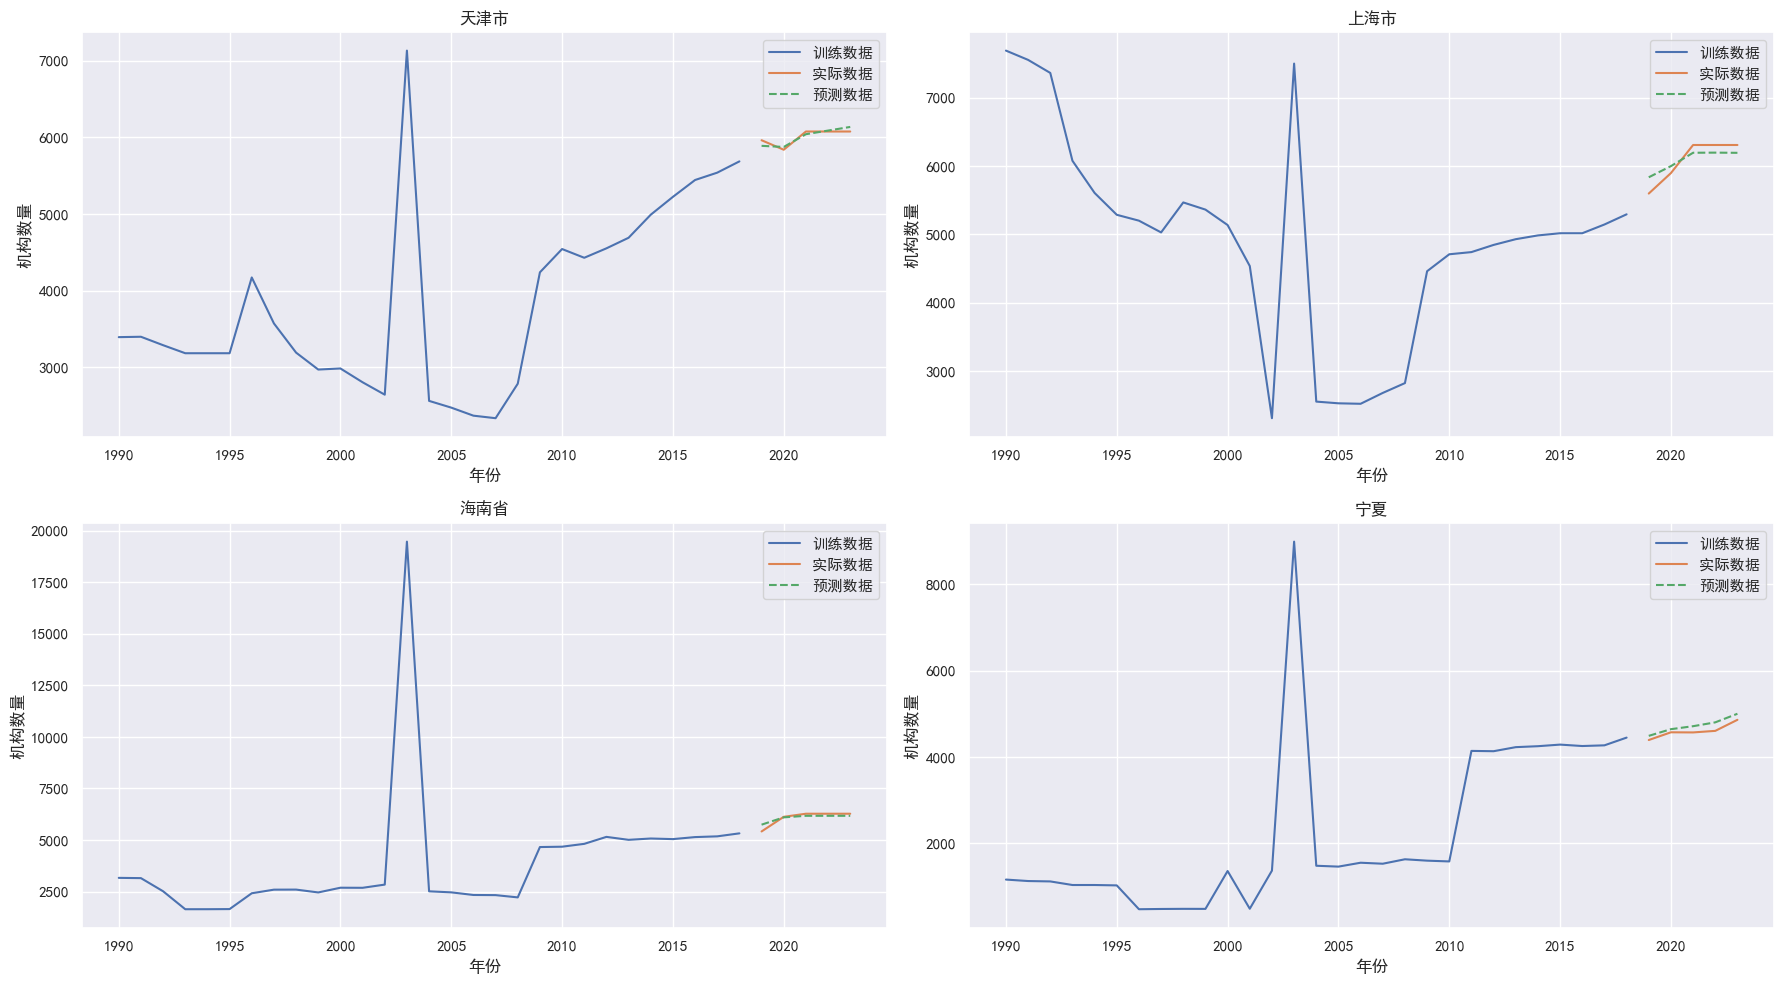

  Region        RMSE         MAE        R2  mae_to_adjust
0    天津市   48.188619   43.307723  0.741174      43.307723
1    上海市  145.399662  136.011914  0.749908     136.011914
2    海南省  167.044904  131.600000  0.750000     131.600000
3     宁夏  137.109391  130.155489  0.166268     130.155489


In [2]:
# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['天津市', '上海市', '海南省', '宁夏']

# 初始化一个空的DataFrame用于存储评估结果
evaluation_results = pd.DataFrame(columns=['Region', 'RMSE', 'MAE', 'R2'])

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values

    # 分为训练集和测试集
    train_data = data[:-5]  # 训练集为所有数据，但留出最后3年做测试
    test_data = data[-5:]   # 最后3年作为测试集

    # 使用 auto_arima 选择最优的 ARIMA 模型
    model = auto_arima(train_data, 
                       seasonal=True,
                       stepwise=True,   # 逐步搜索模型
                       trace=True,      # 显示搜索过程
                       error_action='ignore',  # 忽略搜索时的错误
                       suppress_warnings=True, # 忽略警告
                       maxiter=20)  # 允许的最大迭代次数

    # 拟合模型
    model.fit(train_data)

    # 预测未来5年
    forecast = model.predict(n_periods=5)
    

    # 校正误差
    mae_to_adjust = mean_absolute_error(test_data, forecast)
    forecast = forecast + mae_to_adjust

    # 计算误差指标
    mse = mean_squared_error(test_data, forecast)
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, forecast)

    # 存储评估结果
    new_row = pd.DataFrame({
        'Region': [region],
        'RMSE': [rmse],
        'MAE': [mae],
        'R2': [r2],
        'mae_to_adjust': [mae_to_adjust]
    })
    evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index[:-5], y=train_data, ax=axes[i], label='训练数据')
    sns.lineplot(x=df.index[-5:], y=test_data, ax=axes[i], label='实际数据')
    sns.lineplot(x=df.index[-5:], y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 输出评估结果
evaluation_results.to_csv('./results/auto_arima_evaluation.csv', index=False)


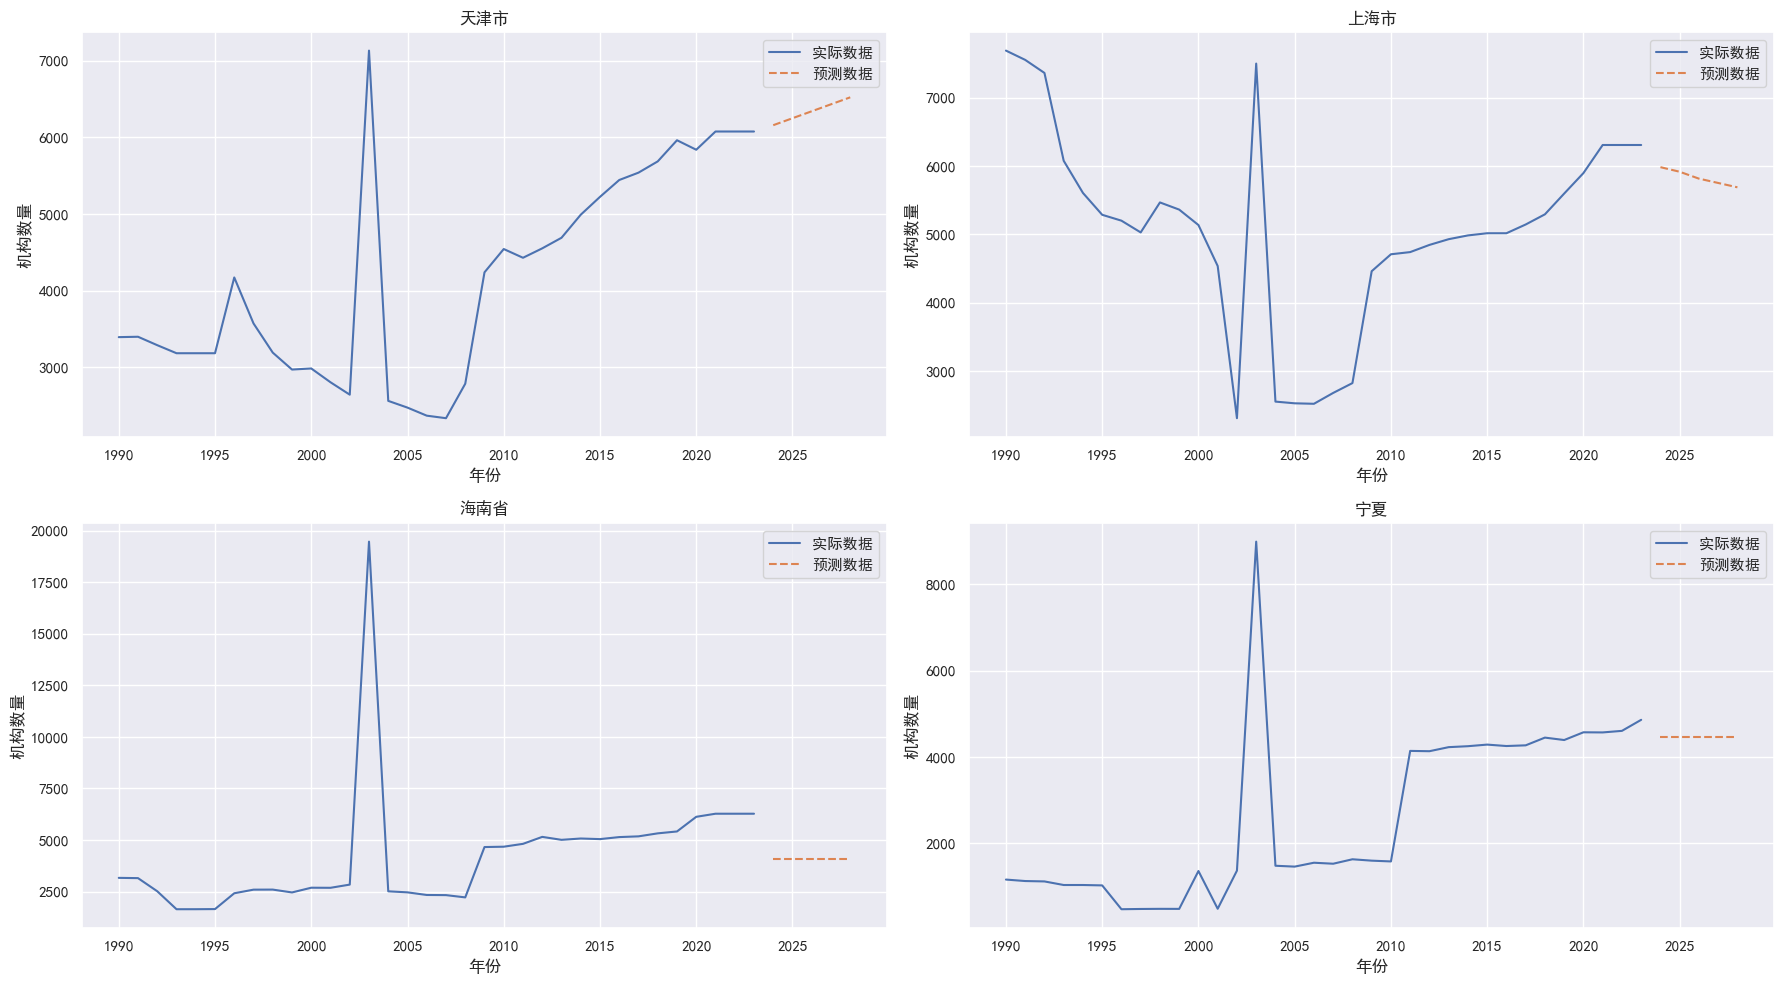

              天津市          上海市          海南省          宁夏
2024  6158.441847  5983.422044  4100.529409  4463.99349
2025  6249.367378  5916.190822  4100.529409  4463.99349
2026  6340.292909  5815.385353  4100.529409  4463.99349
2027  6431.218440  5752.053029  4100.529409  4463.99349
2028  6522.143971  5688.400629  4100.529409  4463.99349


In [3]:
# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['天津市', '上海市', '海南省', '宁夏']

# 预测年份
predict_year = [2024, 2025, 2026, 2027, 2028]

# 创建df来存储预测结果
forecast_df = pd.DataFrame(index=predict_year, columns=regions)

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 最优ARIMA模型参数
best_models = {
    '天津市': (0, 1, 1),
    '上海市': (2, 0, 0),
    '海南省': (0, 0, 0),
    '宁夏': (1, 1, 1)
}

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    # 拟合最优ARIMA模型
    p, d, q = best_models[region]
    model = auto_arima(data_scaled, start_p=p, start_q=q, d=d, max_p=p, max_q=q, seasonal=True, stepwise=True)
    
    # 预测未来5年
    forecast_scaled = model.predict(n_periods=5)
    
    # 将预测值反归一化回原始尺度
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    
    # 校正误差
    error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
    forecast = forecast - error
    
    # 存储预测结果
    s = pd.Series(forecast, index=predict_year)
    forecast_df[region] = s
    
    # 绘制折线图
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index, y=data, ax=axes[i], label='实际数据')
    sns.lineplot(x=predict_year, y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 打印和保存预测结果
print(forecast_df)
forecast_df.to_csv('./results/arima_forecast.csv')